In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm
from sklearn.linear_model import TheilSenRegressor, LinearRegression
import pymannkendall as mk

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/home/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

from ipcc_colormap import *
cmap_prep = ipcc_cmap()
cmap_prep.read_rgb_data_from_excel()
;

''

In [3]:
# a hack from stackoverflow to normalize the colorbar and set arbitrary midpoint locations
# while maintaining the colorbar's linearity
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

# praise claude for this new plotting script
# Function to set common properties for each subplot
def setup_subplot(ax, title, k_data, lon, lat, norm_data, base_cmap):
    ax.coastlines(color='black')
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add title inside the plot
    ax.text(0.005, 0.98, title, transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    return ax.contourf(lon, lat, k_data, vmin=norm_data.vmin, 
                      vmax=norm_data.vmax, cmap=base_cmap, 
                      norm=norm_data, transform=ccrs.PlateCarree())

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, marker = '.', s = 5)

    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)
    xbins = np.linspace(xmin, xmax, 25)
    ybins = np.linspace(ymin, ymax, 25)
    ax_histx.hist(x, bins=xbins)
    ax_histy.hist(y, bins=ybins, orientation='horizontal')
    return 

In [ ]:
# # read nothern hemisphere winter temperature data from raw nc files
# months = [1, 2, 3, 11, 12]
# years = np.arange(1980, 2020, 10)
# data = []
# for yy in years:
#     file_ = path_ + pre_ + str(yy) + '.nc'
#     with xr.open_dataset(file_) as ds:
#         pause = 1
#         t1 = time()
#         for dy in range(10):
#             for mm in months:
#                 if mm == 2:
#                     filter_ds = ds.where((ds.latitude > 0) & (ds.year == yy + dy) & (ds.month == mm) & (ds.day != 29), drop=True)
#                 else:
#                     filter_ds = ds.where((ds.latitude > 0) & (ds.year == yy + dy) & (ds.month == mm), drop=True)
#                 data.append(filter_ds.temperature)
#         print('Time taken for year ', yy, ' is ', time() - t1)

# concatenated_data = xr.concat(data, dim='time')
# temp = concatenated_data.values

# # recover the original values by adding the climatology
# with xr.open_dataset(path_ + pre_ + '1980.nc') as ds:
#     climatology = ds.climatology.values[:,-90:,:]

# # day-of-year mask for Jan-Feb-Mar-Nov-Dec
# doy_l = [0, 31, 59, 304, 334]
# doy_r = [31, 59, 90, 334, 365]
# # day-of-season mask for Jan-Feb-Mar-Nov-Dec
# ll = [0, 31, 59, 90, 120, 151]
# for yy in range(40):
#     t1 = time()
#     for mm in range(5):
#         il, ir = 151*yy + ll[mm], 151*yy + ll[mm+1]
#         temp[il:ir,:,:] += climatology[doy_l[mm]:doy_r[mm],:,:]
#     print('Time taken for year ', yy, ' is ', time() - t1)

# output = open('NH_winter_temp.pkl', 'wb')
# pickle.dump(temp, output)
# output.close()


In [4]:
# i concatenated two chunks of codes here and you may find duplicate variables (t_50 and temp_median)
# but im too lazy to clean it up so bear with me
# read processed data from pkl file
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]
climatology = np.mean(temp, axis=0)

temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
t_50 = np.zeros((39, 90, 360))
t_95 = np.zeros((39, 90, 360))
t_5 = np.zeros((39, 90, 360))

for yy in range(39):
    left, right = yy*151, (yy+1)*151

    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian

    t50 = np.percentile(temp[left:right, :, :], 50, axis=0)
    t95 = np.percentile(temp[left:right, :, :], 95, axis=0)
    t5 = np.percentile(temp[left:right, :, :], 5, axis=0)
    t_50[yy, :, :] = t50
    t_95[yy, :, :] = t95
    t_5[yy, :, :] = t5

# mask out nan values in temperatures
mask = 1 - np.isnan(np.mean(temp_mean, axis=0))
# the 1-deg mask (mask2) is downscaled from the 2-deg from Gottlieb 2024 et al.
mask2 = np.loadtxt('mask_1deg.txt')
mask = mask * mask2

In [5]:
# compute median and mean trends
# i followed Gottlieb 2024 to use a Theil-Sen estimator for trends 
# and i used the mann kendal test for the trend significance 
# according to this post https://stats.stackexchange.com/questions/646424/how-to-test-significance-of-theil-sen-estimate
# the significance test should be 'compatible' with the estimator
k_mean = np.zeros((90, 360))
k_median = np.zeros((90, 360))
pv_mean = np.zeros((90, 360))
pv_median = np.zeros((90, 360))

diff_v = []
k_median_v = []

# compute trends of 50th, 95th, and 5th percentile temperatures
k50 = np.zeros((90, 360))
k5 = np.zeros((90, 360))
k95 = np.zeros((90, 360))
pv50 = np.zeros((90, 360))
pv5 = np.zeros((90, 360))
pv95 = np.zeros((90, 360))

## define 4 types of distributional alteration:
# type i: both tails stretch                            := 5th - 50th <= 0, 95th - 50th > 0
# type ii: both tails shrink                            := 5th - 50th > 0, 95th - 50th <= 0
# type iii: cold tail shrinks, warm tail stretches      := 5th - 50th > 0, 95th - 50th > 0
# type iv: cold tail stretches, warm tail shrinks       := 5th - 50th <= 0, 95th - 50th <= 0
type_map = np.zeros((90, 360))

# define the cold/warm tail's outpacing relative to the median trend
cold_diff = []
warm_diff = []

climatology_v = [] # vectorized climatology for later scatter plots
xx = np.arange(39) # years
cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)
        

        # mean and median trends
        lm1 = TheilSenRegressor(random_state=42)
        lm1.fit(xx[:,None], temp_mean[:,i,j])
        k_mean[i,j] = lm1.coef_[0] * 10
        mk_res1 = mk.original_test(temp_mean[:,i,j])
        pv_mean[i,j] = mk_res1.p

        lm2 = TheilSenRegressor(random_state=42)
        lm2.fit(xx[:,None], temp_median[:,i,j])
        k_median[i,j] = lm2.coef_[0] * 10
        mk_res2 = mk.original_test(temp_median[:,i,j])
        pv_median[i,j] = mk_res2.p
        
        diff_v.append(k_median[i,j] - k_mean[i,j])
        k_median_v.append(k_median[i,j])

        # 50th, 95th, and 5th percentile trends
        lm50 = TheilSenRegressor(random_state=42)
        lm50.fit(xx[:,None], t_50[:,i,j])
        k50[i,j] = lm50.coef_[0] * 10
        mk_res50 = mk.original_test(t_50[:,i,j])
        pv50[i,j] = mk_res50.p

        lm5 = TheilSenRegressor(random_state=42)
        lm5.fit(xx[:,None], t_5[:,i,j])
        k5[i,j] = lm5.coef_[0] * 10
        mk_res5 = mk.original_test(t_5[:,i,j])
        pv5[i,j] = mk_res1.p

        lm95 = TheilSenRegressor(random_state=42)
        lm95.fit(xx[:,None], t_95[:,i,j])
        k95[i,j] = lm95.coef_[0] * 10
        mk_res95 = mk.original_test(t_95[:,i,j])
        pv95[i,j] = mk_res2.p

        # vectorize some useful variabils for later analysis
        climatology_v.append(climatology[i,j])
        cold_diff.append(k5[i,j] - k50[i,j])
        warm_diff.append(k95[i,j] - k50[i,j])

        # record the type of distributional alteration
        if k5[i,j] - k50[i,j] <= 0 and k95[i,j] - k50[i,j] > 0:
            type_map[i,j] = 1
        elif k5[i,j] - k50[i,j] > 0 and k95[i,j] - k50[i,j] <= 0:
            type_map[i,j] = 2
        elif k5[i,j] - k50[i,j] > 0 and k95[i,j] - k50[i,j] > 0:
            type_map[i,j] = 3
        else:
            type_map[i,j] = 4

# list to numpy array
diff_v = np.array(diff_v)
k_median_v = np.array(k_median_v)
cold_diff = np.array(cold_diff)
warm_diff = np.array(warm_diff)
climatology_v = np.array(climatology_v)

Processing  1000  grids. Time taken so far:  54.403550148010254
Processing  2000  grids. Time taken so far:  109.68615674972534
Processing  3000  grids. Time taken so far:  161.80443382263184
Processing  4000  grids. Time taken so far:  213.94143223762512
Processing  5000  grids. Time taken so far:  268.1161353588104
Processing  6000  grids. Time taken so far:  323.36654329299927
Processing  7000  grids. Time taken so far:  380.2700424194336


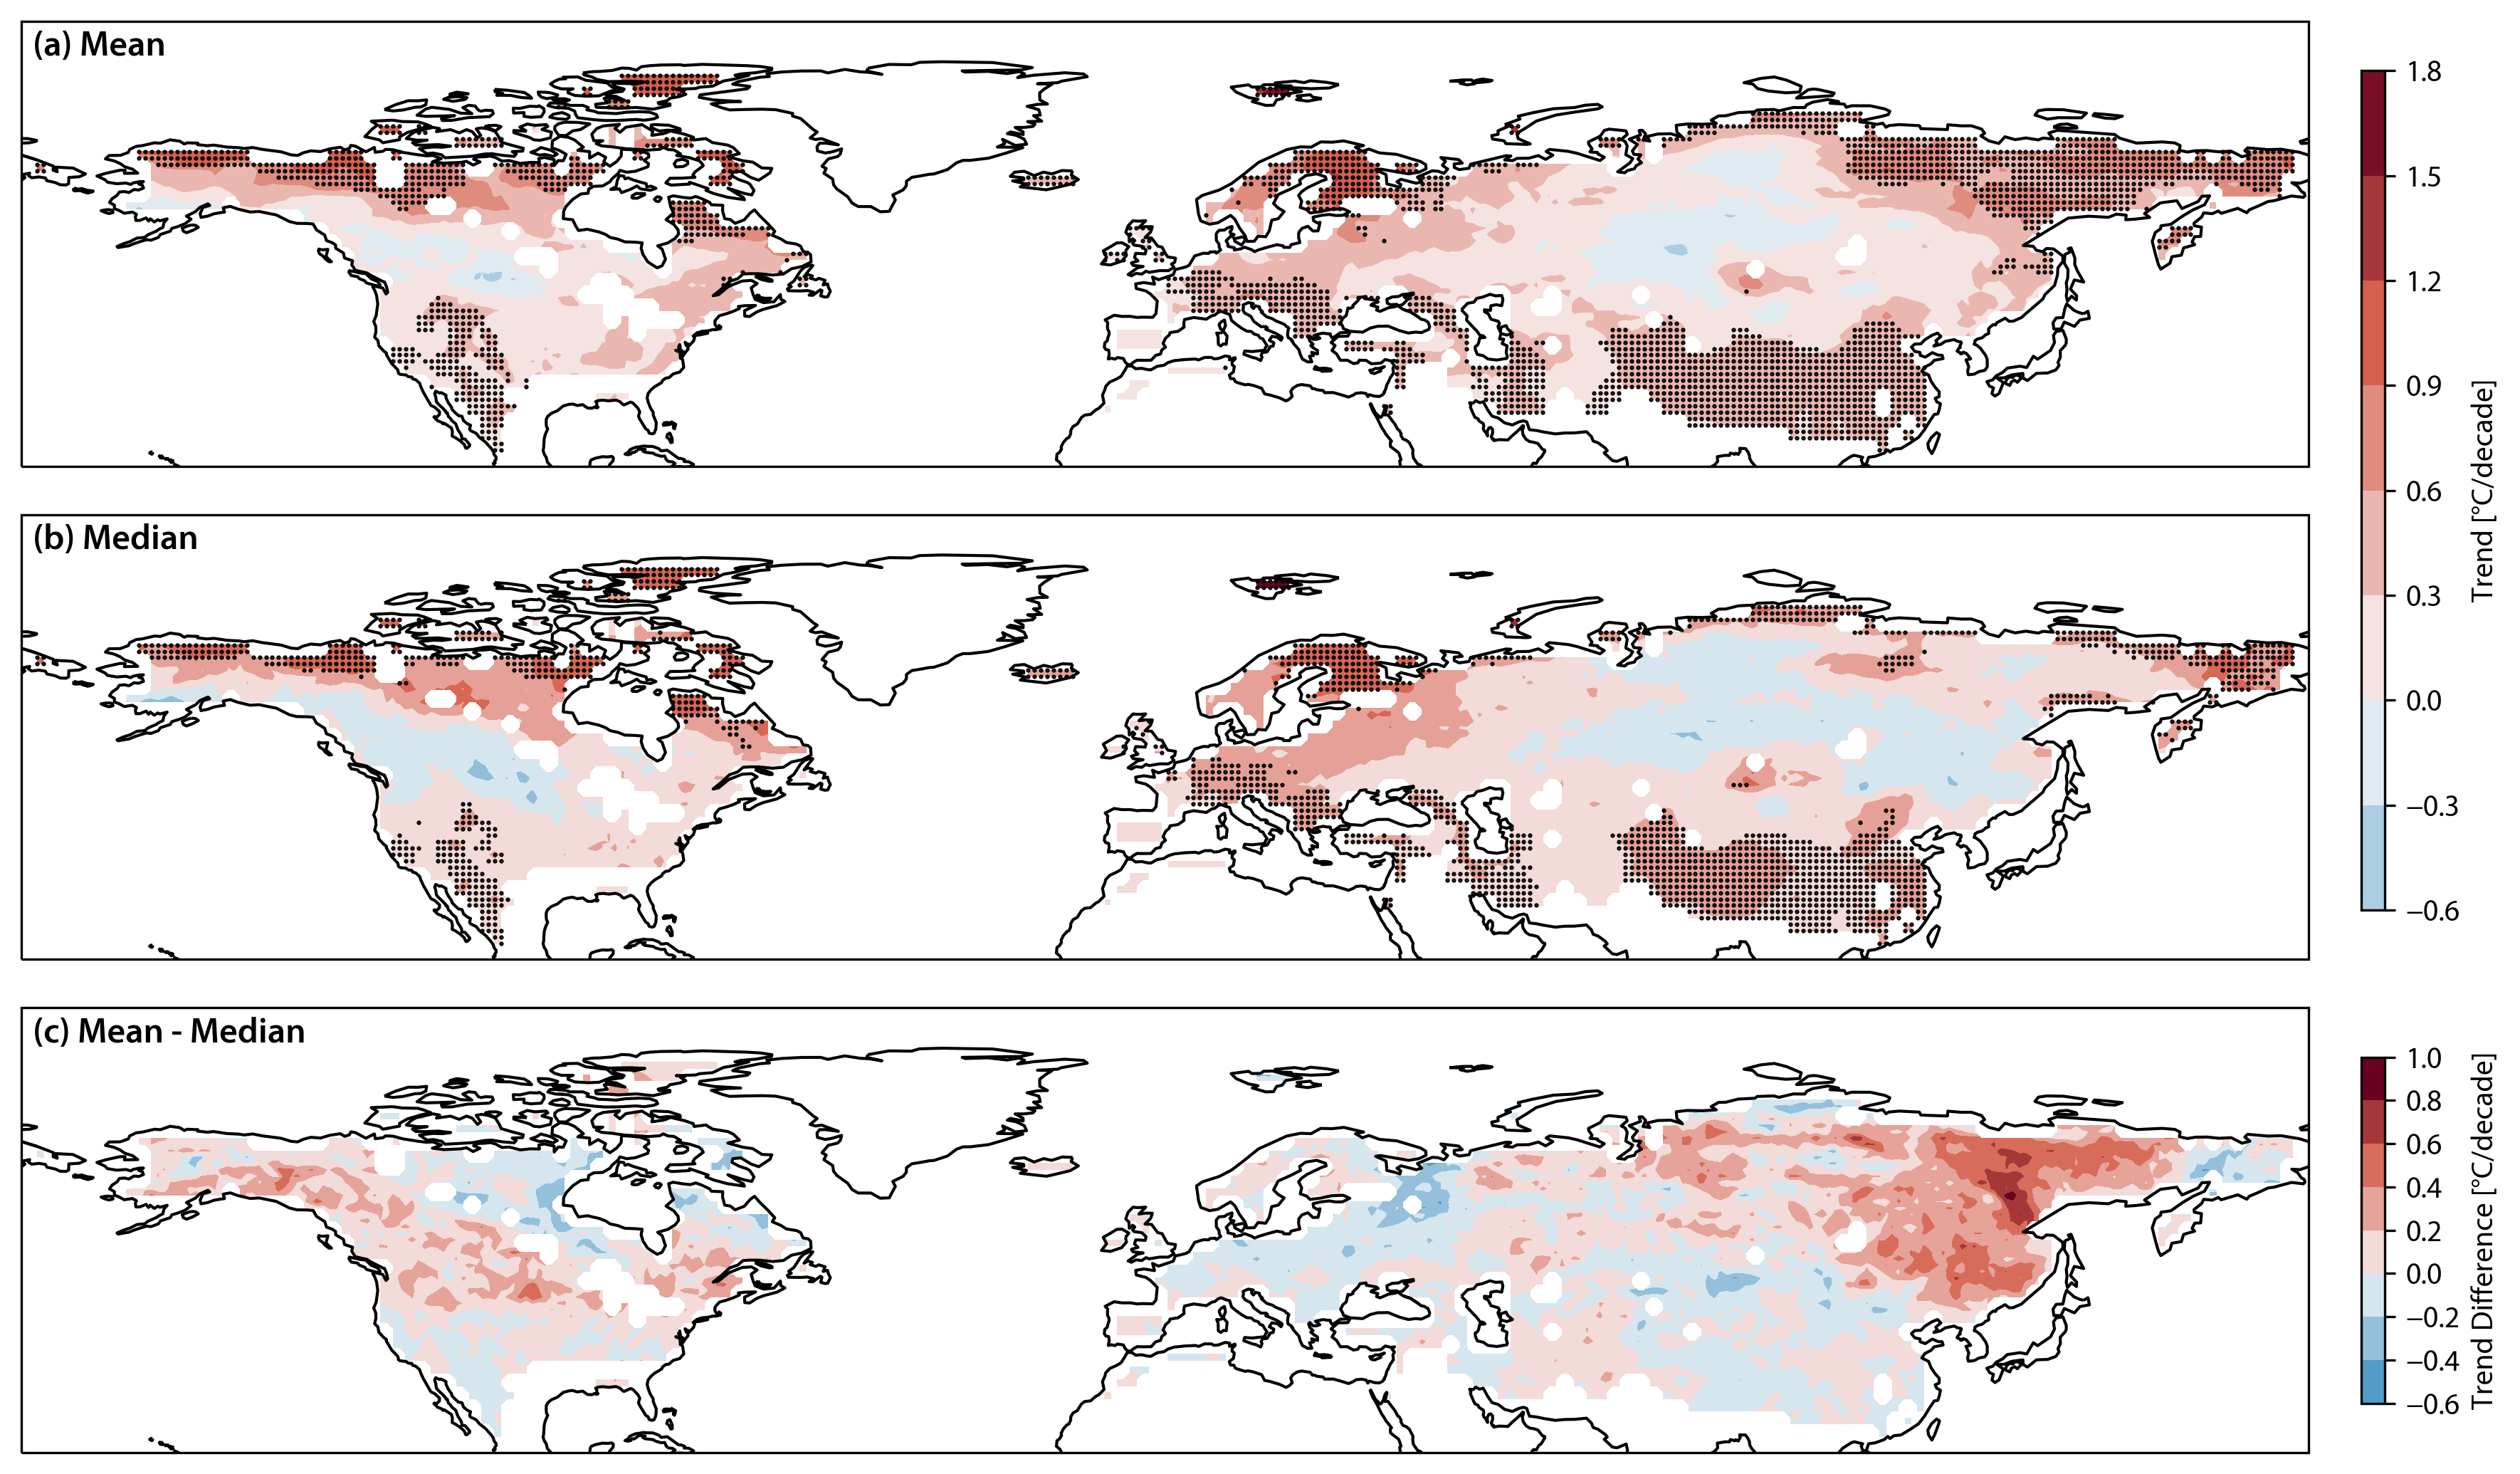

In [6]:
# plot median and mean trends
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)
pv_mean[mask == 0] = 1
pv_median[mask == 0] = 1

# Create masked arrays for the data
k_mean_masked = np.ma.masked_where(mask == 0, k_mean)
k_median_masked = np.ma.masked_where(mask == 0, k_median)

trend_max = np.max([np.max(k_mean), np.max(k_median)])
trend_min = np.min([np.min(k_mean), np.min(k_median)])

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 21, reverse = False)
# Add white color for masked values
cmap.set_bad('white')

fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

# Mean Trend plot
ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
basemap0 = setup_subplot(ax0, '(a) Mean', k_mean_masked, lons, lats, norm, cmap)
ax0.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
lons_mean = lons[pv_mean <= 0.05]
lats_mean = lats[pv_mean <= 0.05]
ax0.scatter(lons_mean, lats_mean, color='black', marker='.', s=1)

# Median Trend plot
ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
basemap1 = setup_subplot(ax1, '(b) Median', k_median_masked, lon, lat, norm, cmap)
ax1.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
lons_median = lons[pv_median <= 0.05]
lats_median = lats[pv_median <= 0.05]
ax1.scatter(lons_median, lats_median, color='black', marker='.', s=1)

# Trend Diff plot
ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
diff_min = np.min(k_mean - k_median)
diff_max = np.max(k_mean - k_median)
diff_norm = MidpointNormalize(vmin=diff_min, vmax=diff_max, midpoint=0)
diff_masked = np.ma.masked_where(mask == 0, k_mean - k_median)
basemap2 = setup_subplot(ax2, '(c) Mean - Median', 
                        diff_masked, lon, lat, diff_norm, cmap)
ax2.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())

# Shared colorbar for the first two plots
cbar_ax = fig.add_subplot(gs[1:19, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [°C/decade]')

# Independent colorbar for the third plot
cbar_ax2 = fig.add_subplot(gs[21:29, 1])
cbar2 = plt.colorbar(basemap2, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Trend Difference [°C/decade]')

fig.tight_layout()
plt.show()
fig.savefig('figures_new/mean_vs_median_trend.png')

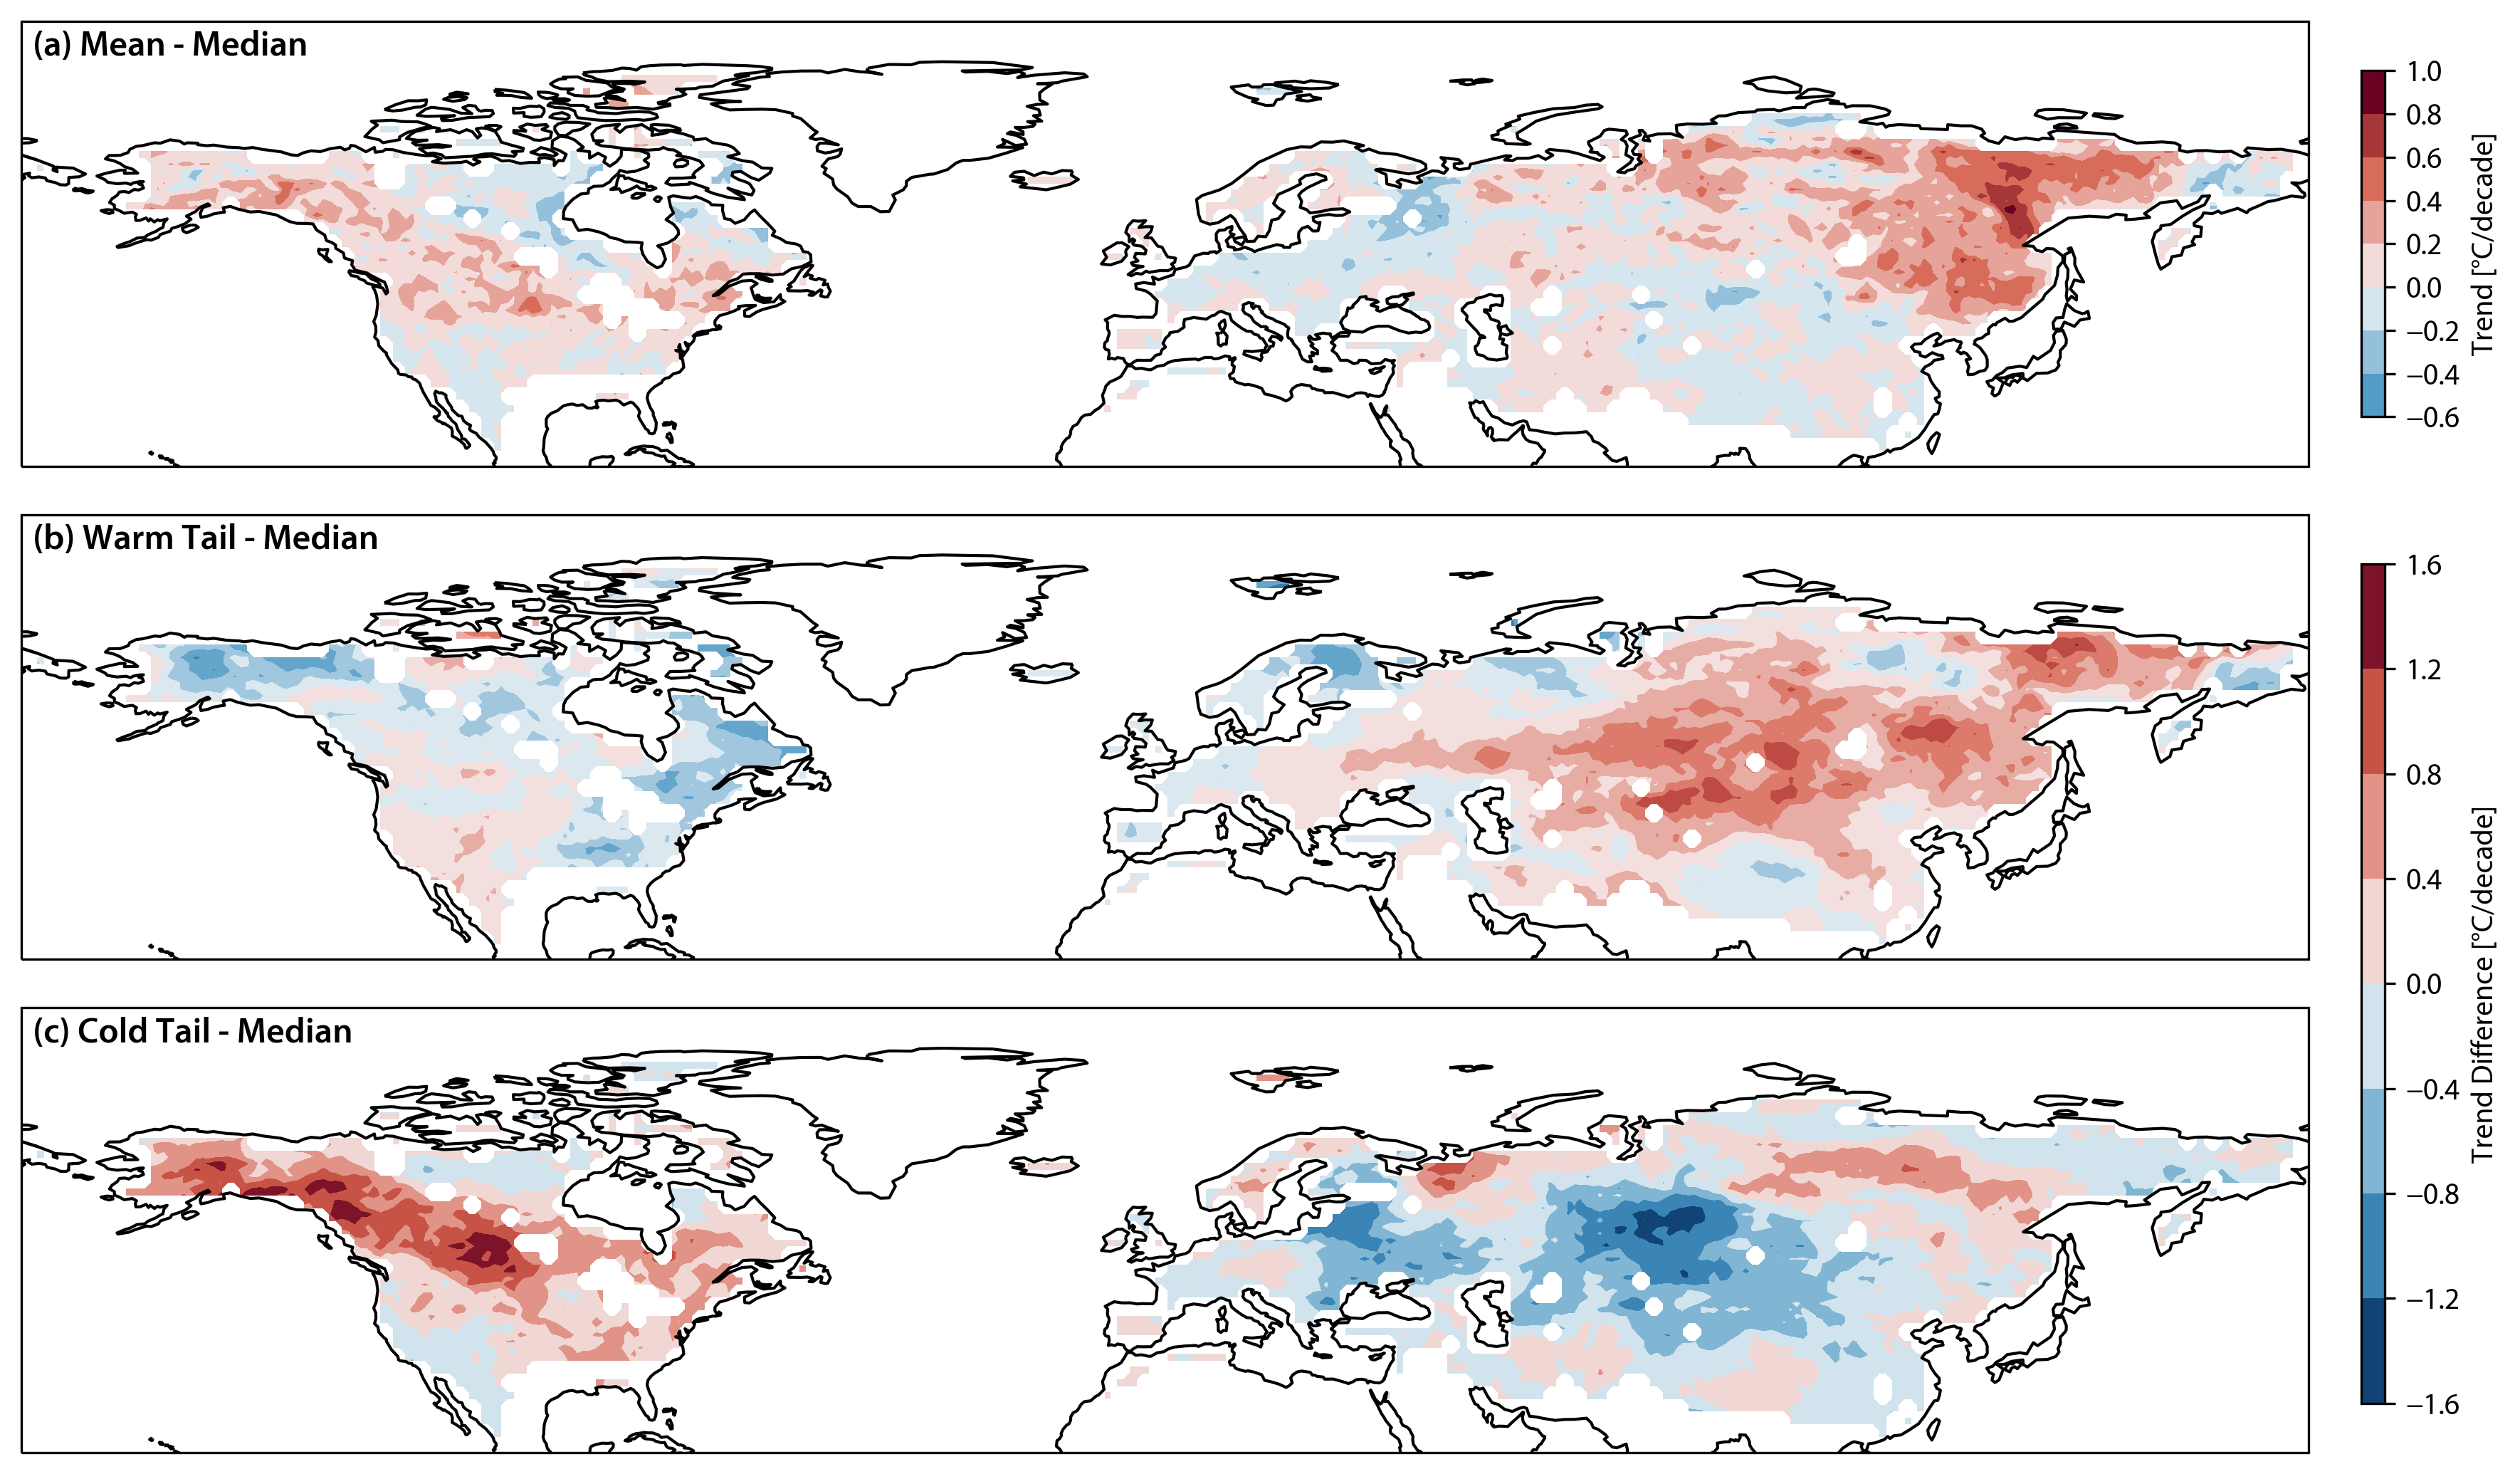

In [ ]:
# plot warm and cold tails' outpace relative to the median
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)

pv5[mask == 0] = 1
pv50[mask == 0] = 1
pv95[mask == 0] = 1

cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 21, reverse = False)
# Add white color for masked values
cmap.set_bad('white')

fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

# Median trend plot for reference
diff_min = np.min(k_mean - k_median)
diff_max = np.max(k_mean - k_median)
diff_norm = MidpointNormalize(vmin=diff_min, vmax=diff_max, midpoint=0)
diff_masked = np.ma.masked_where(mask == 0, k_mean - k_median)
ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
basemap0 = setup_subplot(ax0, '(a) Mean - Median', diff_masked , lons, lats, diff_norm, cmap)
ax0.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())

# compare trends of tails (5th and 95th percentiles) to the median
diff_min = np.min([np.min(k5 - k50), np.min(k95 - k50)])
diff_max = np.max([np.max(k5 - k50), np.max(k95 - k50)])

norm1 = MidpointNormalize(vmin=diff_min, vmax=diff_max, midpoint=0)
# Warm Tail - Median trends
ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())

warm_diff_masked = np.ma.masked_where(mask == 0, k95 - k50)

basemap1 = setup_subplot(ax1, '(b) Warm Tail - Median', warm_diff_masked, lon, lat, norm1, cmap)
ax1.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
# Cold Tail - Median trends
ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())

cold_diff_masked = np.ma.masked_where(mask == 0, k5 - k50)

basemap2 = setup_subplot(ax2, '(c) Cold Tail - Median', cold_diff_masked, lon, lat, norm1, cmap)
ax2.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())

# Shared colorbar for the first two plots
cbar_ax = fig.add_subplot(gs[1:9, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [°C/decade]')

# Independent colorbar for the third plot
cbar_ax2 = fig.add_subplot(gs[11:29, 1])
cbar2 = plt.colorbar(basemap2, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Trend Difference [°C/decade]')

fig.tight_layout()
plt.show()
fig.savefig('figures_new/warm_cold_vs_median.png')

Correlation between [Mean - Median] and [5th percentile - Median]:  0.5042642811160499


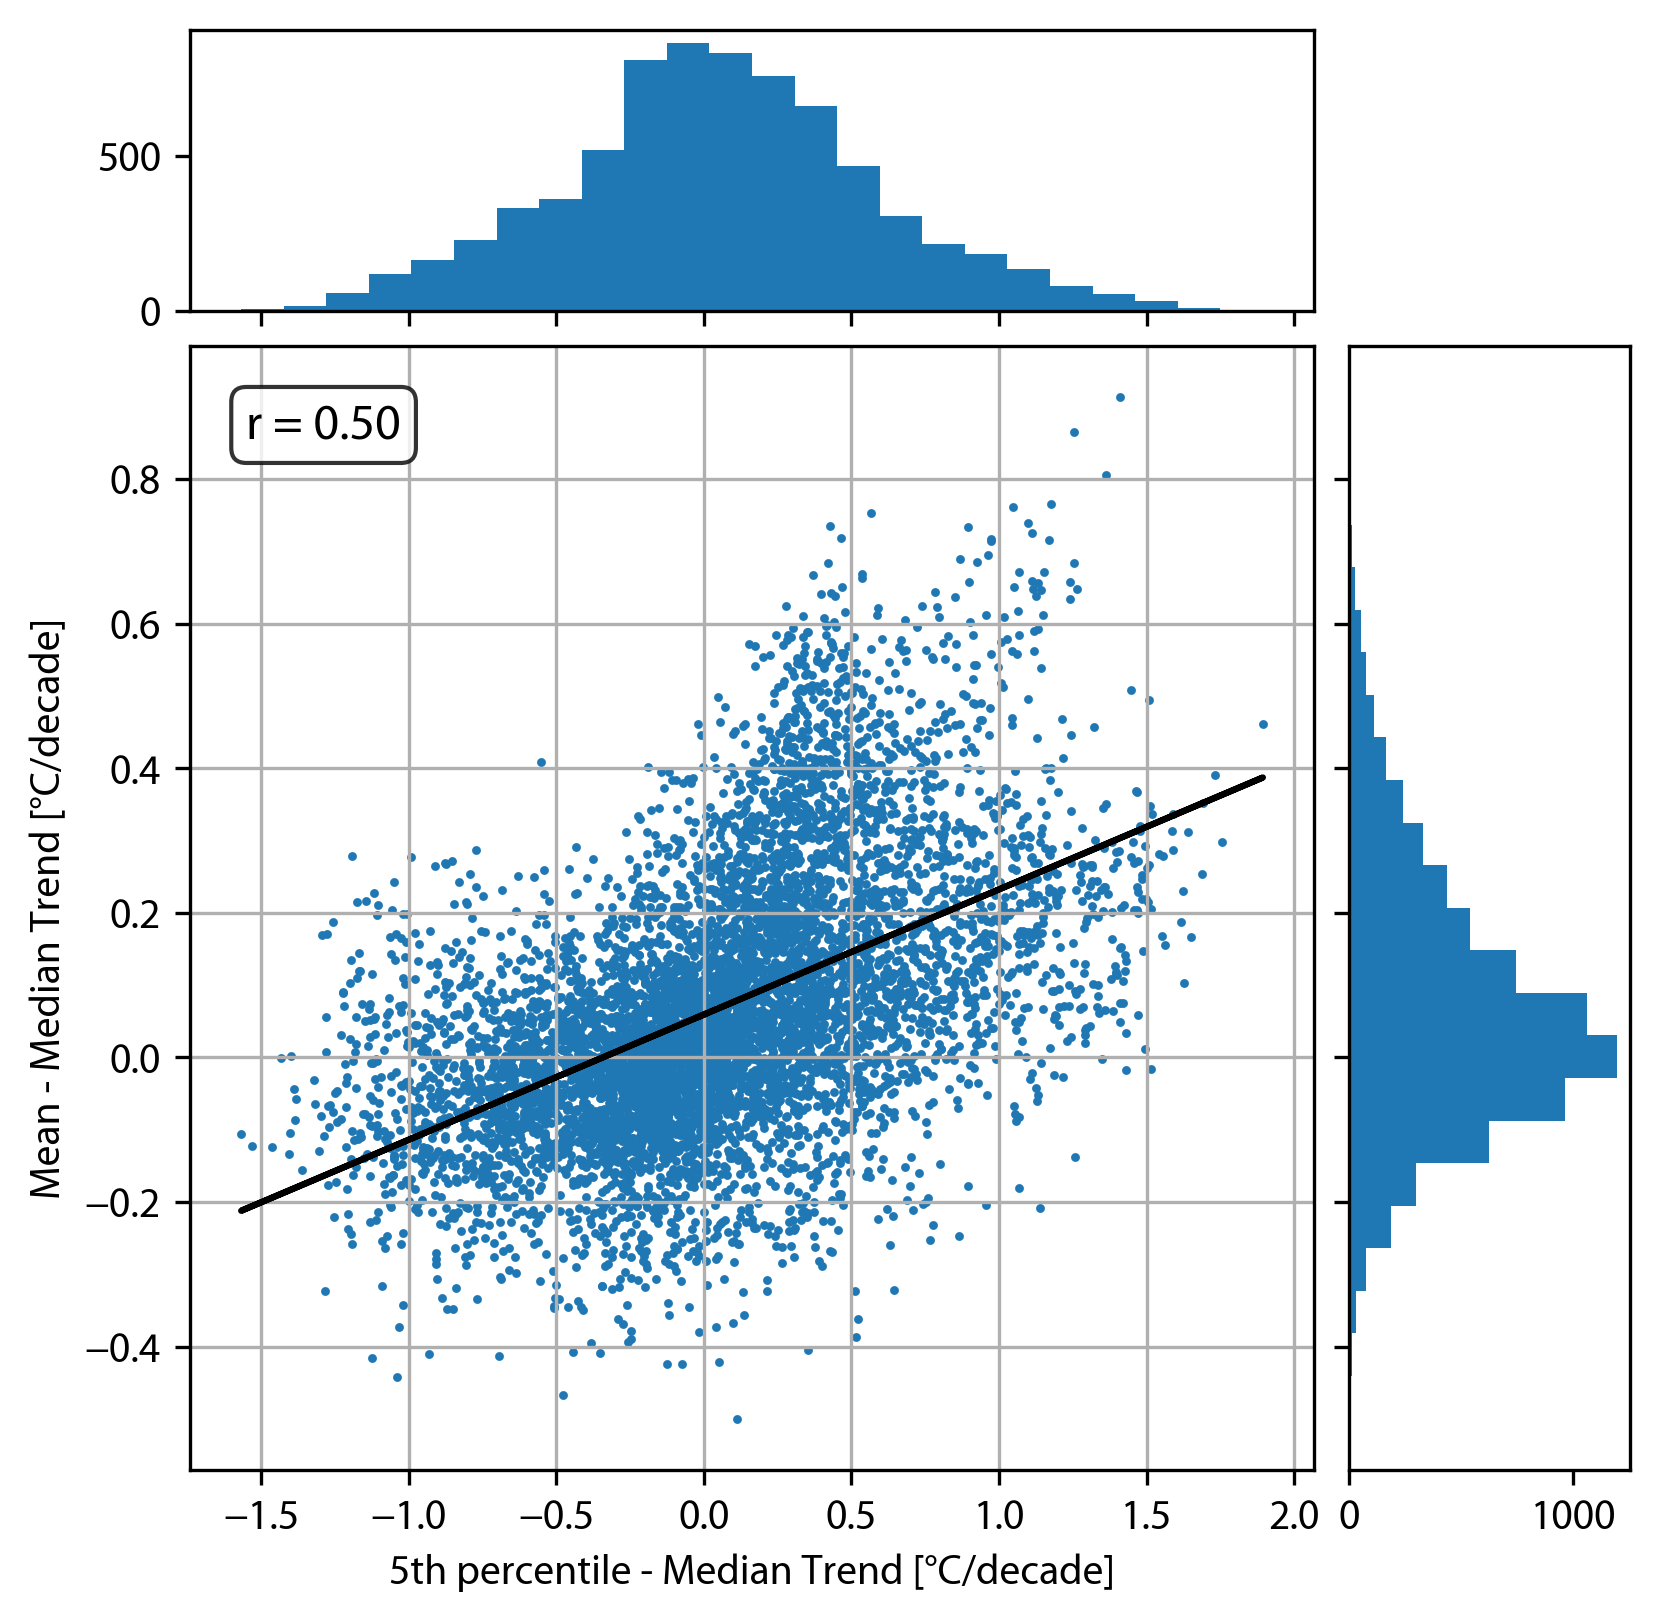

In [8]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(cold_diff, -diff_v, ax, ax_histx, ax_histy)
lm = LinearRegression().fit(cold_diff.reshape(-1, 1), -diff_v)
ax.plot(cold_diff, lm.predict(cold_diff.reshape(-1, 1)), color='black')
ax.set_ylabel('Mean - Median Trend [°C/decade]')
ax.set_xlabel('5th percentile - Median Trend [°C/decade]')
ax.grid(True)
# Calculate correlation coefficient
corr_coef = np.corrcoef(-diff_v, cold_diff)[0, 1]
print('Correlation between [Mean - Median] and [5th percentile - Median]: ', corr_coef)
# Add textbox with correlation coefficient
textstr = f'r = {corr_coef:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.show()
fig.savefig('figures_new/cold_tail_diff_vs_mean_diff.png')

Correlation between [Mean - Median] and [5th percentile - Median]:  0.5632271985066831


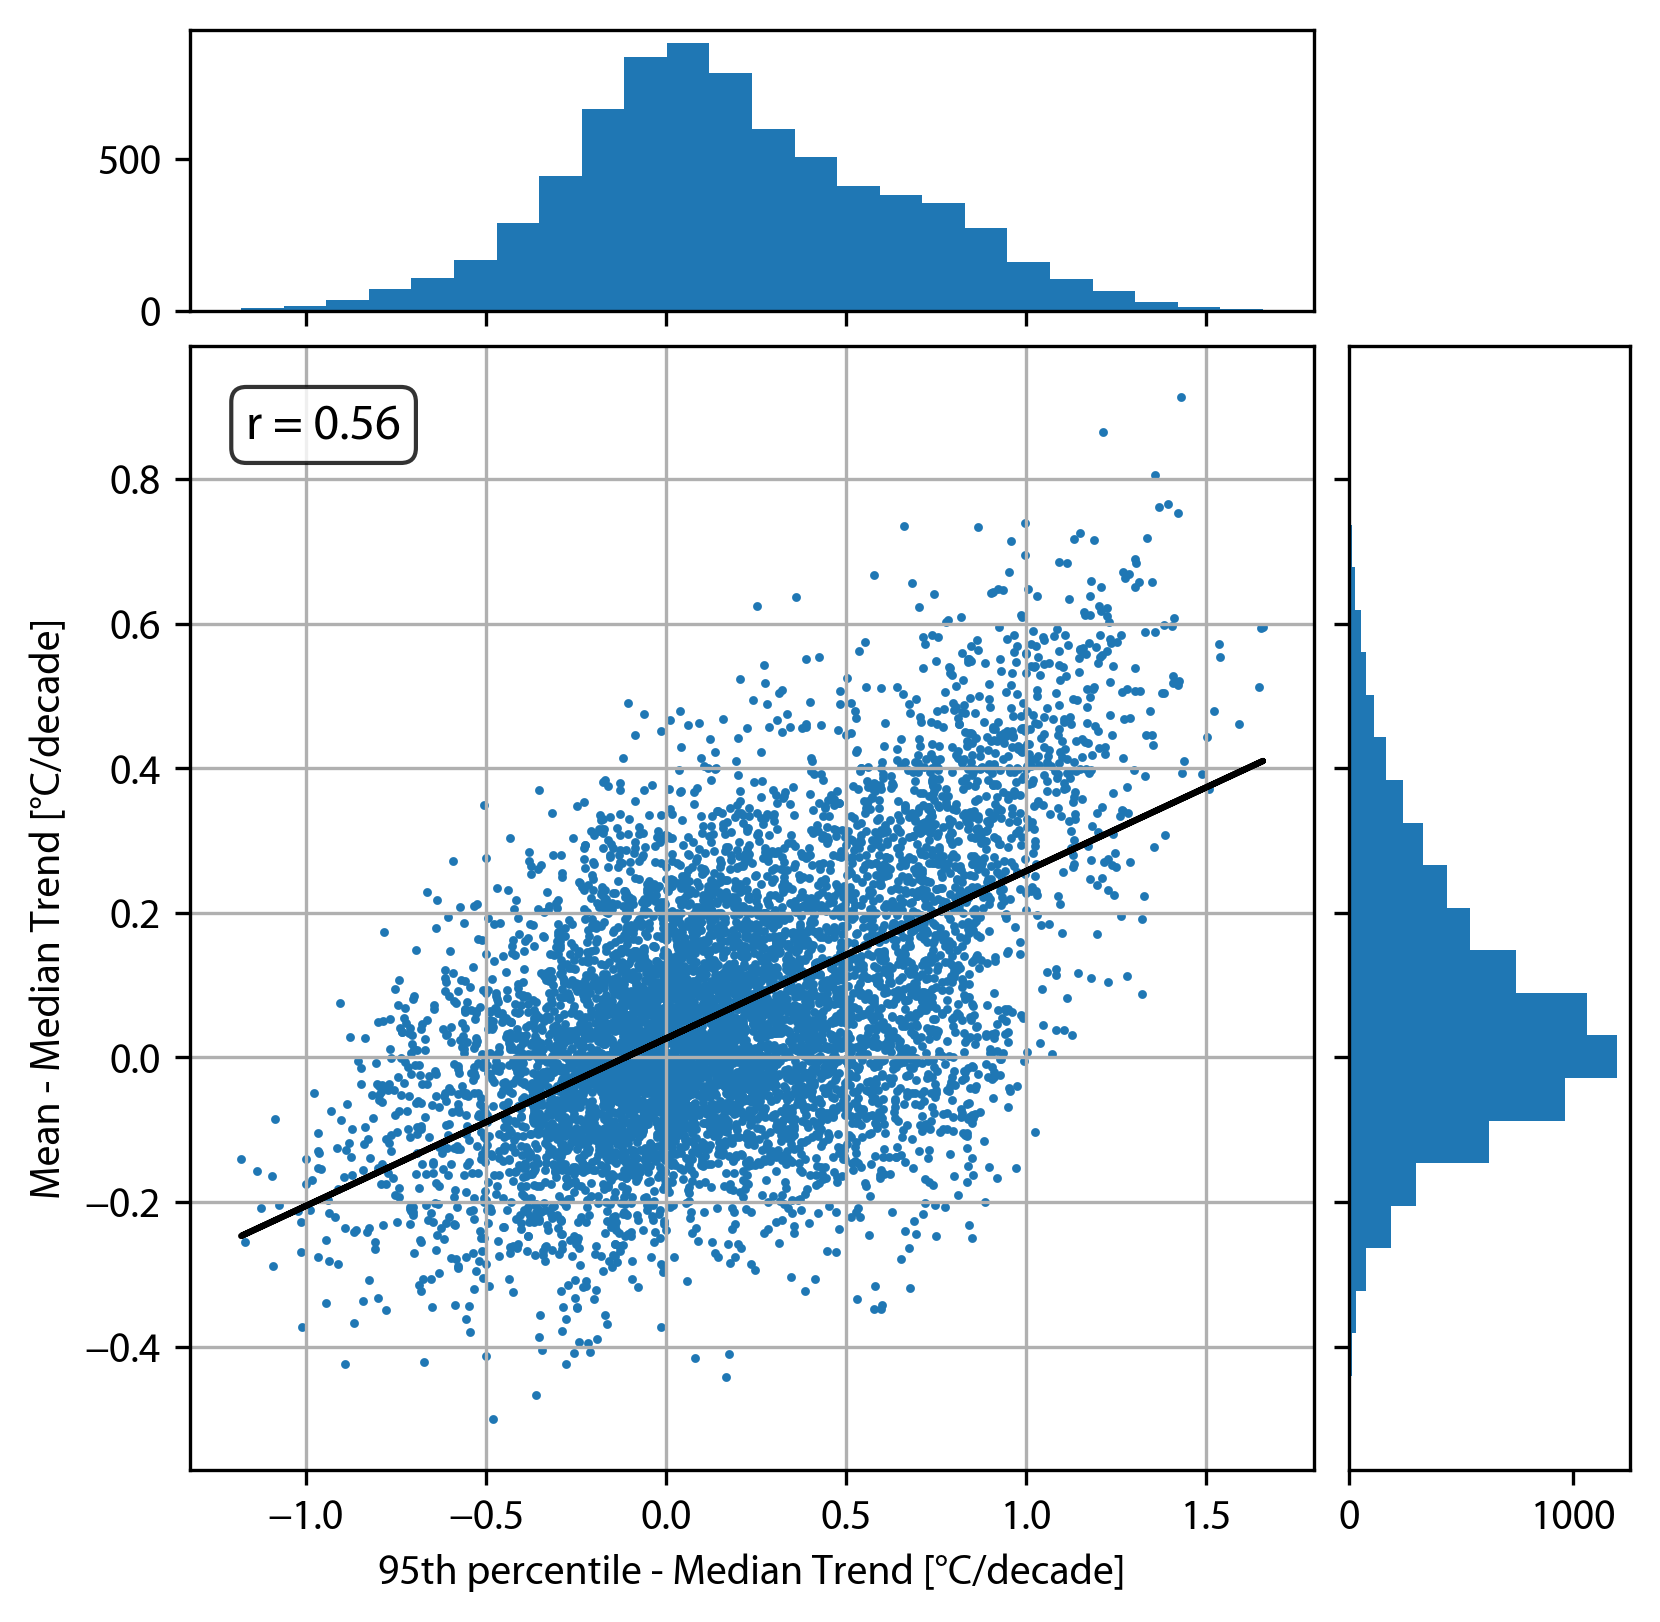

In [9]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(warm_diff, -diff_v, ax, ax_histx, ax_histy)
lm = LinearRegression().fit(warm_diff.reshape(-1, 1), -diff_v)
ax.plot(warm_diff, lm.predict(warm_diff.reshape(-1, 1)), color='black')
ax.set_ylabel('Mean - Median Trend [°C/decade]')
ax.set_xlabel('95th percentile - Median Trend [°C/decade]')
ax.grid(True)
# Calculate correlation coefficient
corr_coef = np.corrcoef(-diff_v, warm_diff)[0, 1]
print('Correlation between [Mean - Median] and [5th percentile - Median]: ', corr_coef)
# Add textbox with correlation coefficient
textstr = f'r = {corr_coef:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.show()
fig.savefig('figures_new/warm_tail_diff_vs_mean_diff.png')

Correlation between [Mean - Median] and [5th percentile - Median]:  -0.08324330697024071


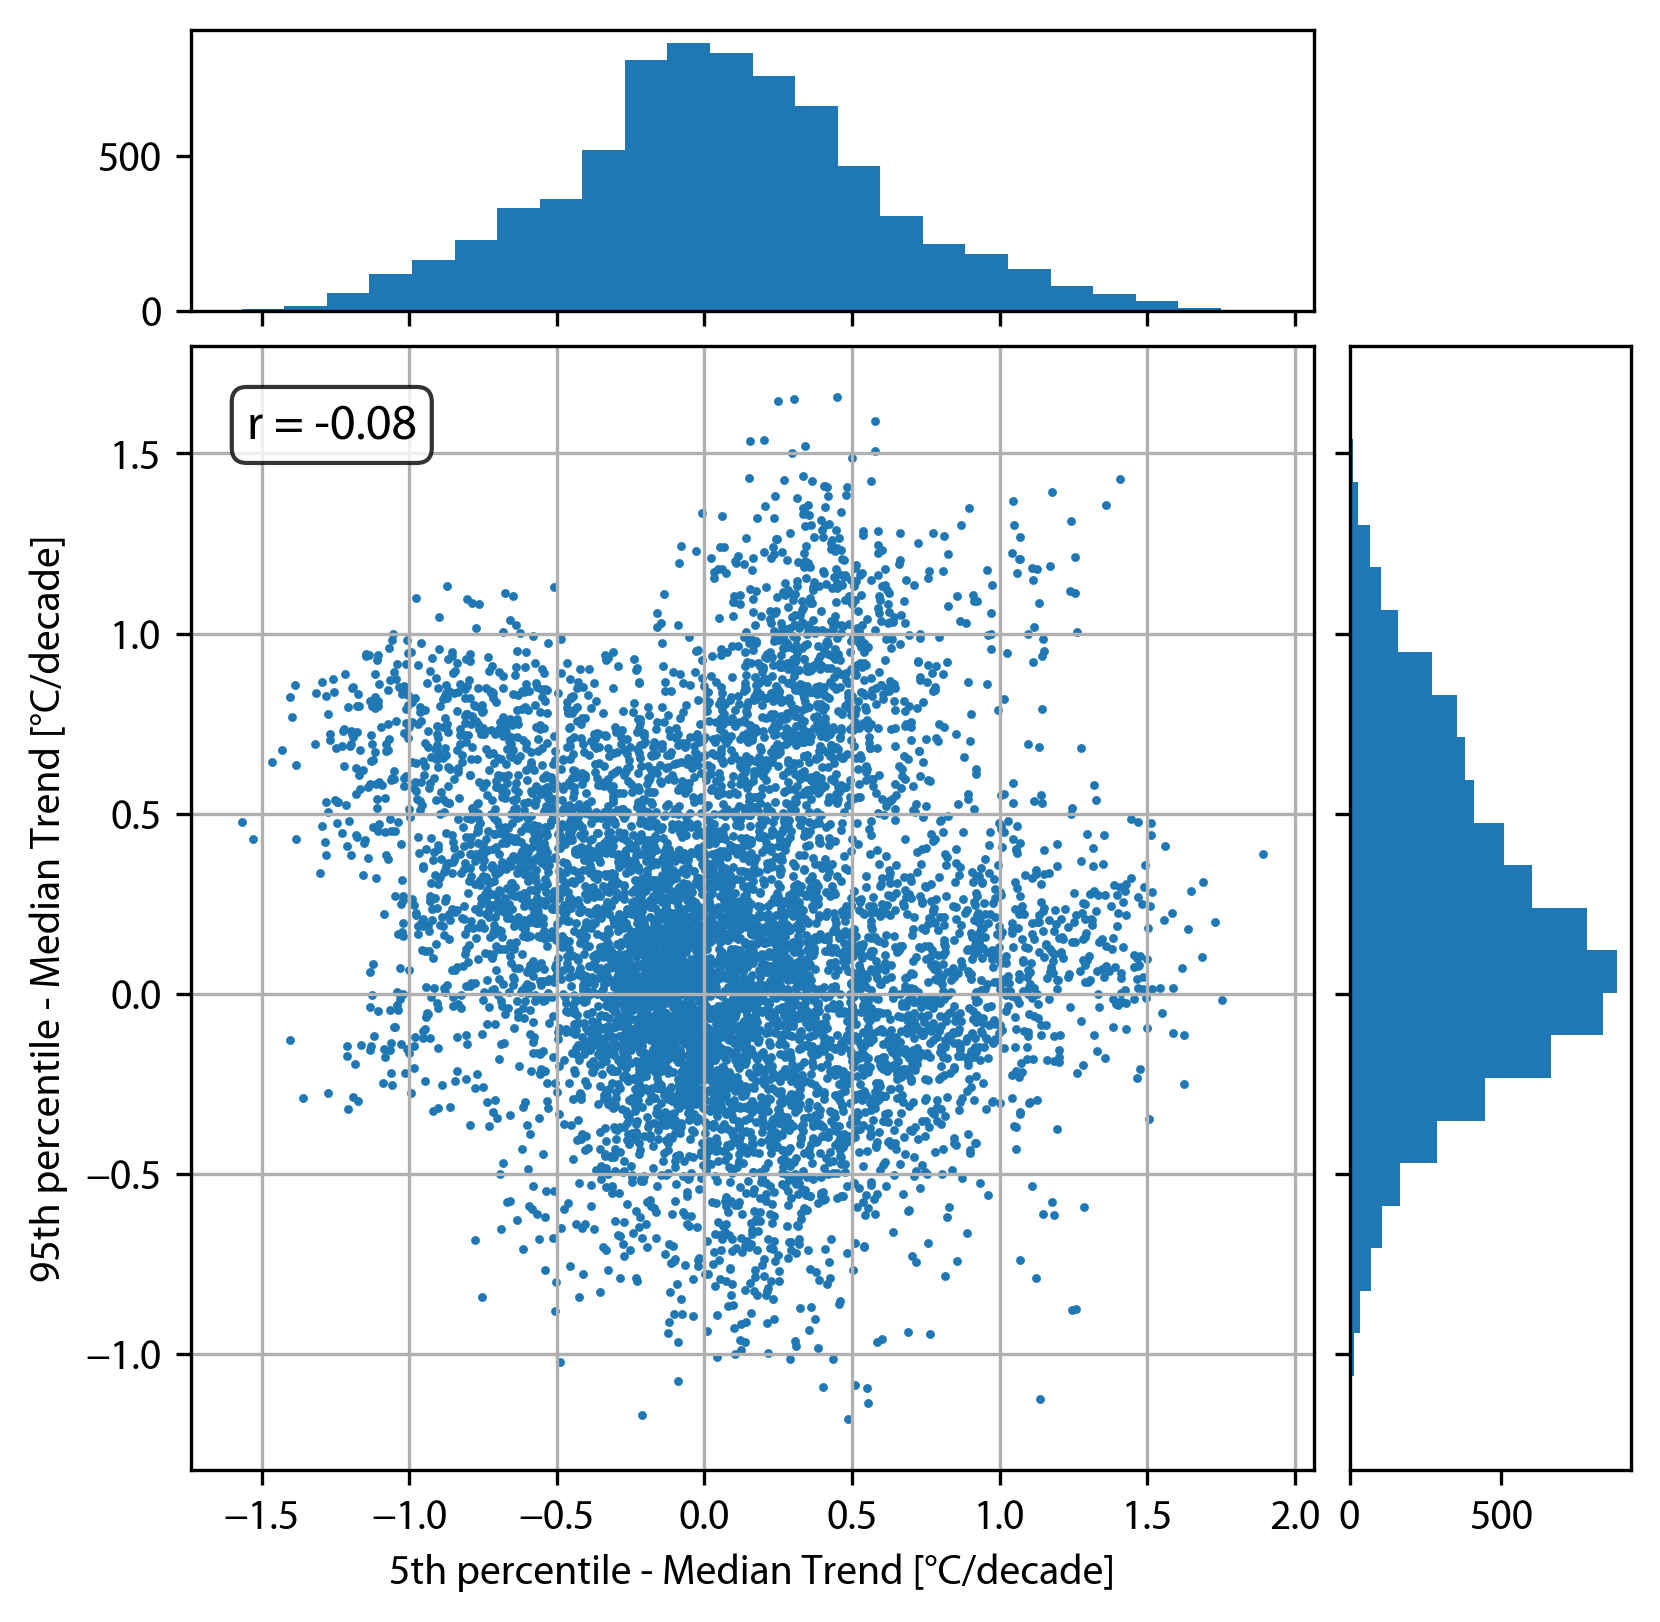

In [10]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(cold_diff, warm_diff, ax, ax_histx, ax_histy)
ax.set_xlabel('5th percentile - Median Trend [°C/decade]')
ax.set_ylabel('95th percentile - Median Trend [°C/decade]')
ax.grid(True)
# Calculate correlation coefficient
corr_coef = np.corrcoef(warm_diff, cold_diff)[0, 1]
print('Correlation between [Mean - Median] and [5th percentile - Median]: ', corr_coef)
# Add textbox with correlation coefficient
textstr = f'r = {corr_coef:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.show()
fig.savefig('figures_new/cold_tail_diff_vs_warm_tail_diff.png')

Correlation between [Mean - Median] and [5th percentile - Median]:  0.7893731091521499


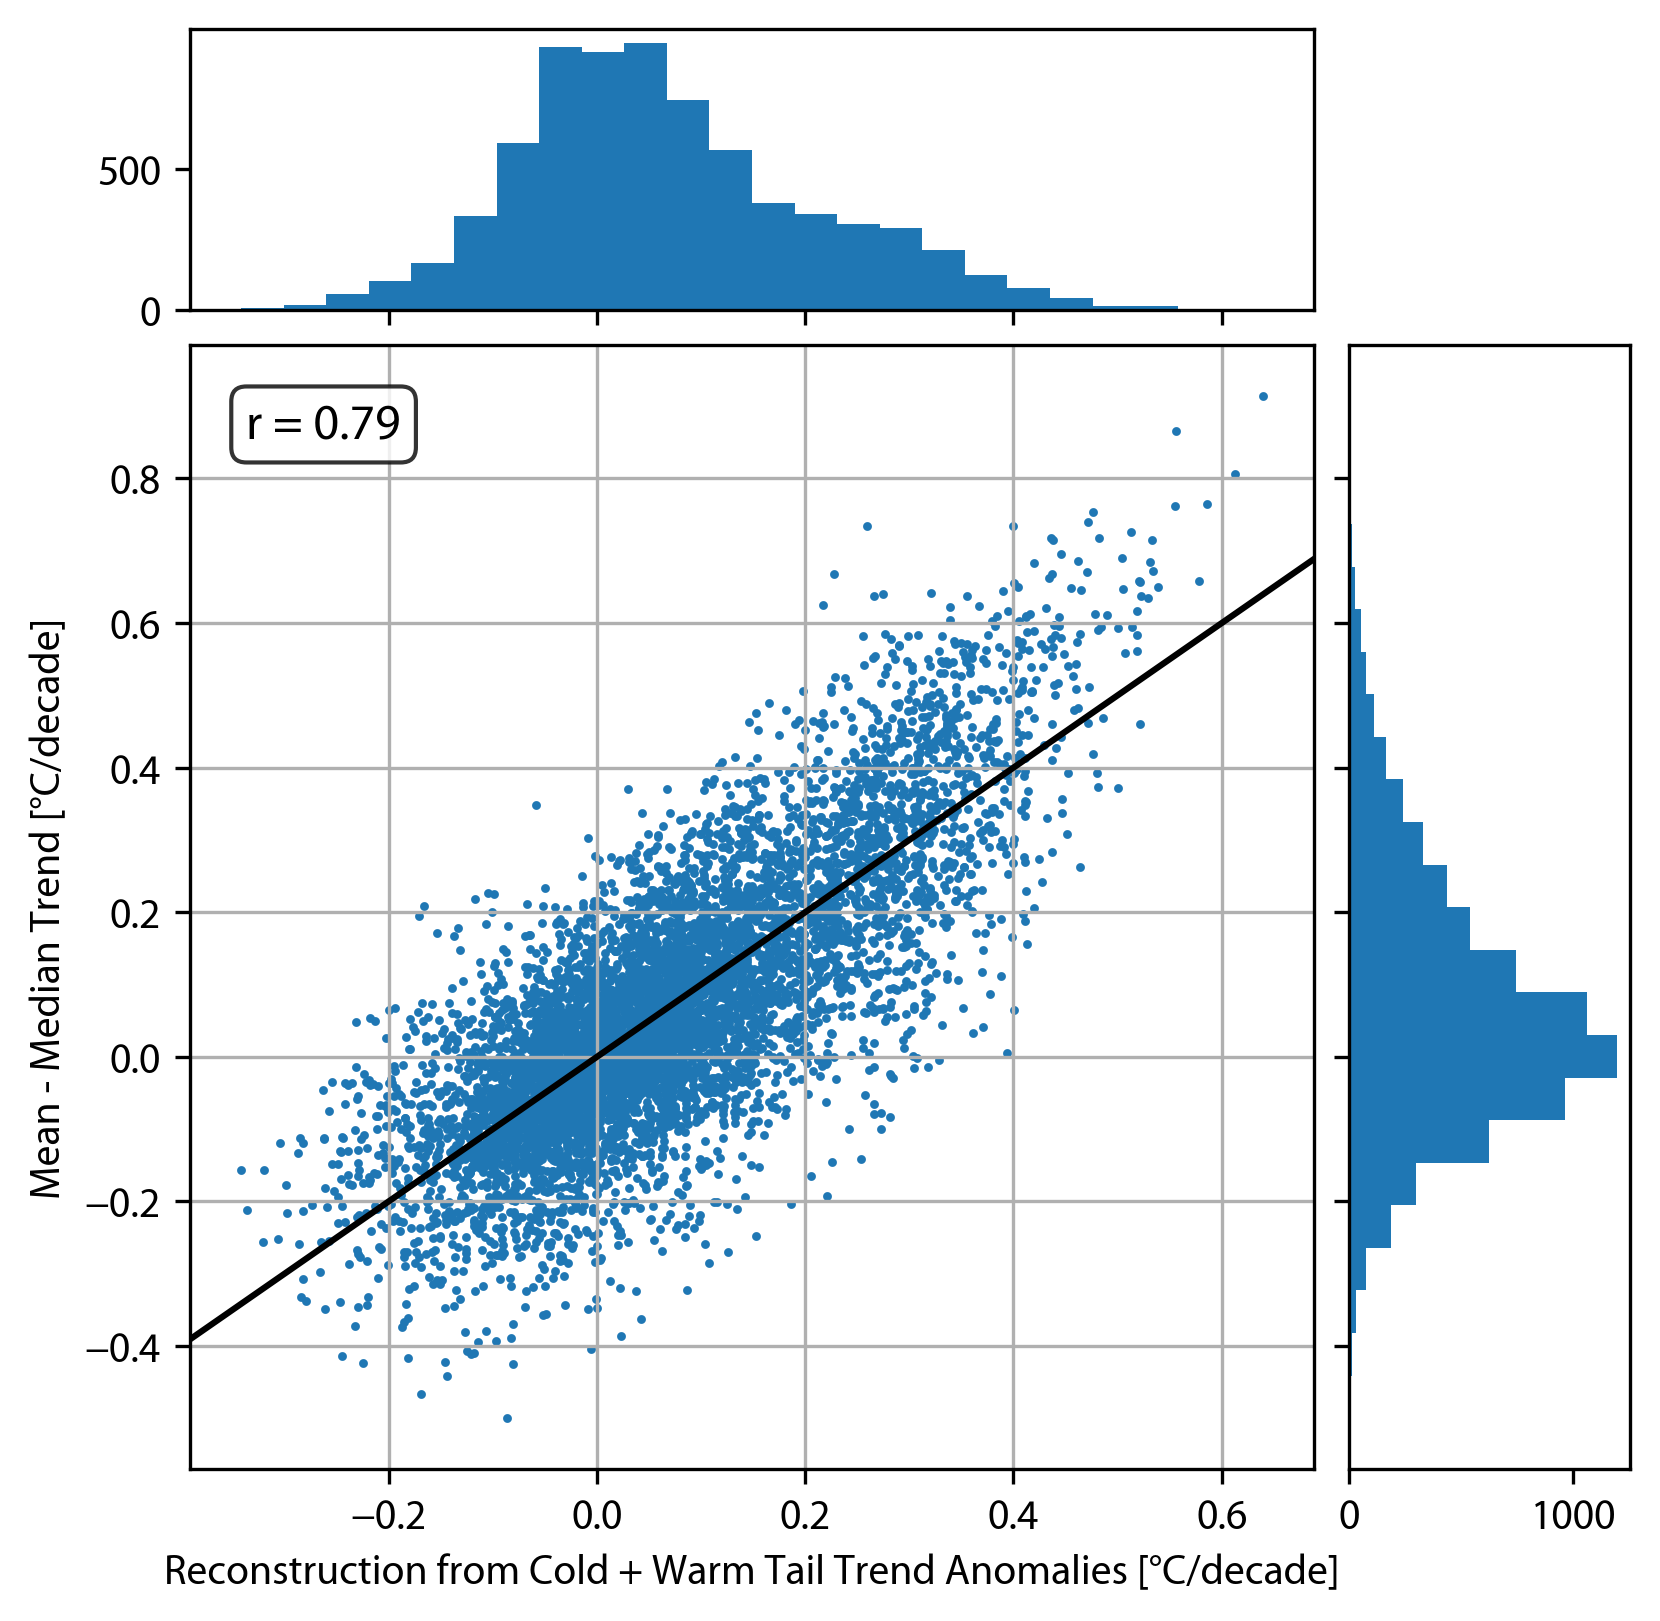

In [11]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
XX = np.concatenate((cold_diff.reshape(-1, 1), warm_diff.reshape(-1, 1)), axis=1)
lm = LinearRegression().fit(XX, -diff_v)
# Draw the scatter plot and marginals
predictand = lm.predict(XX)
scatter_hist(predictand, -diff_v, ax, ax_histx, ax_histy)
ax.axline((0, 0), slope=1, color='black')
ax.set_xlabel('Reconstruction from Cold + Warm Tail Trend Anomalies [°C/decade]')
ax.set_ylabel('Mean - Median Trend [°C/decade]')
ax.grid(True)
# Calculate correlation coefficient
corr_coef = np.corrcoef(predictand, -diff_v)[0, 1]
print('Correlation between [Mean - Median] and [5th percentile - Median]: ', corr_coef)
# Add textbox with correlation coefficient
textstr = f'r = {corr_coef:.2f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.show()
fig.savefig('figures_new/bivariate_diff_vs_mean_diff.png')

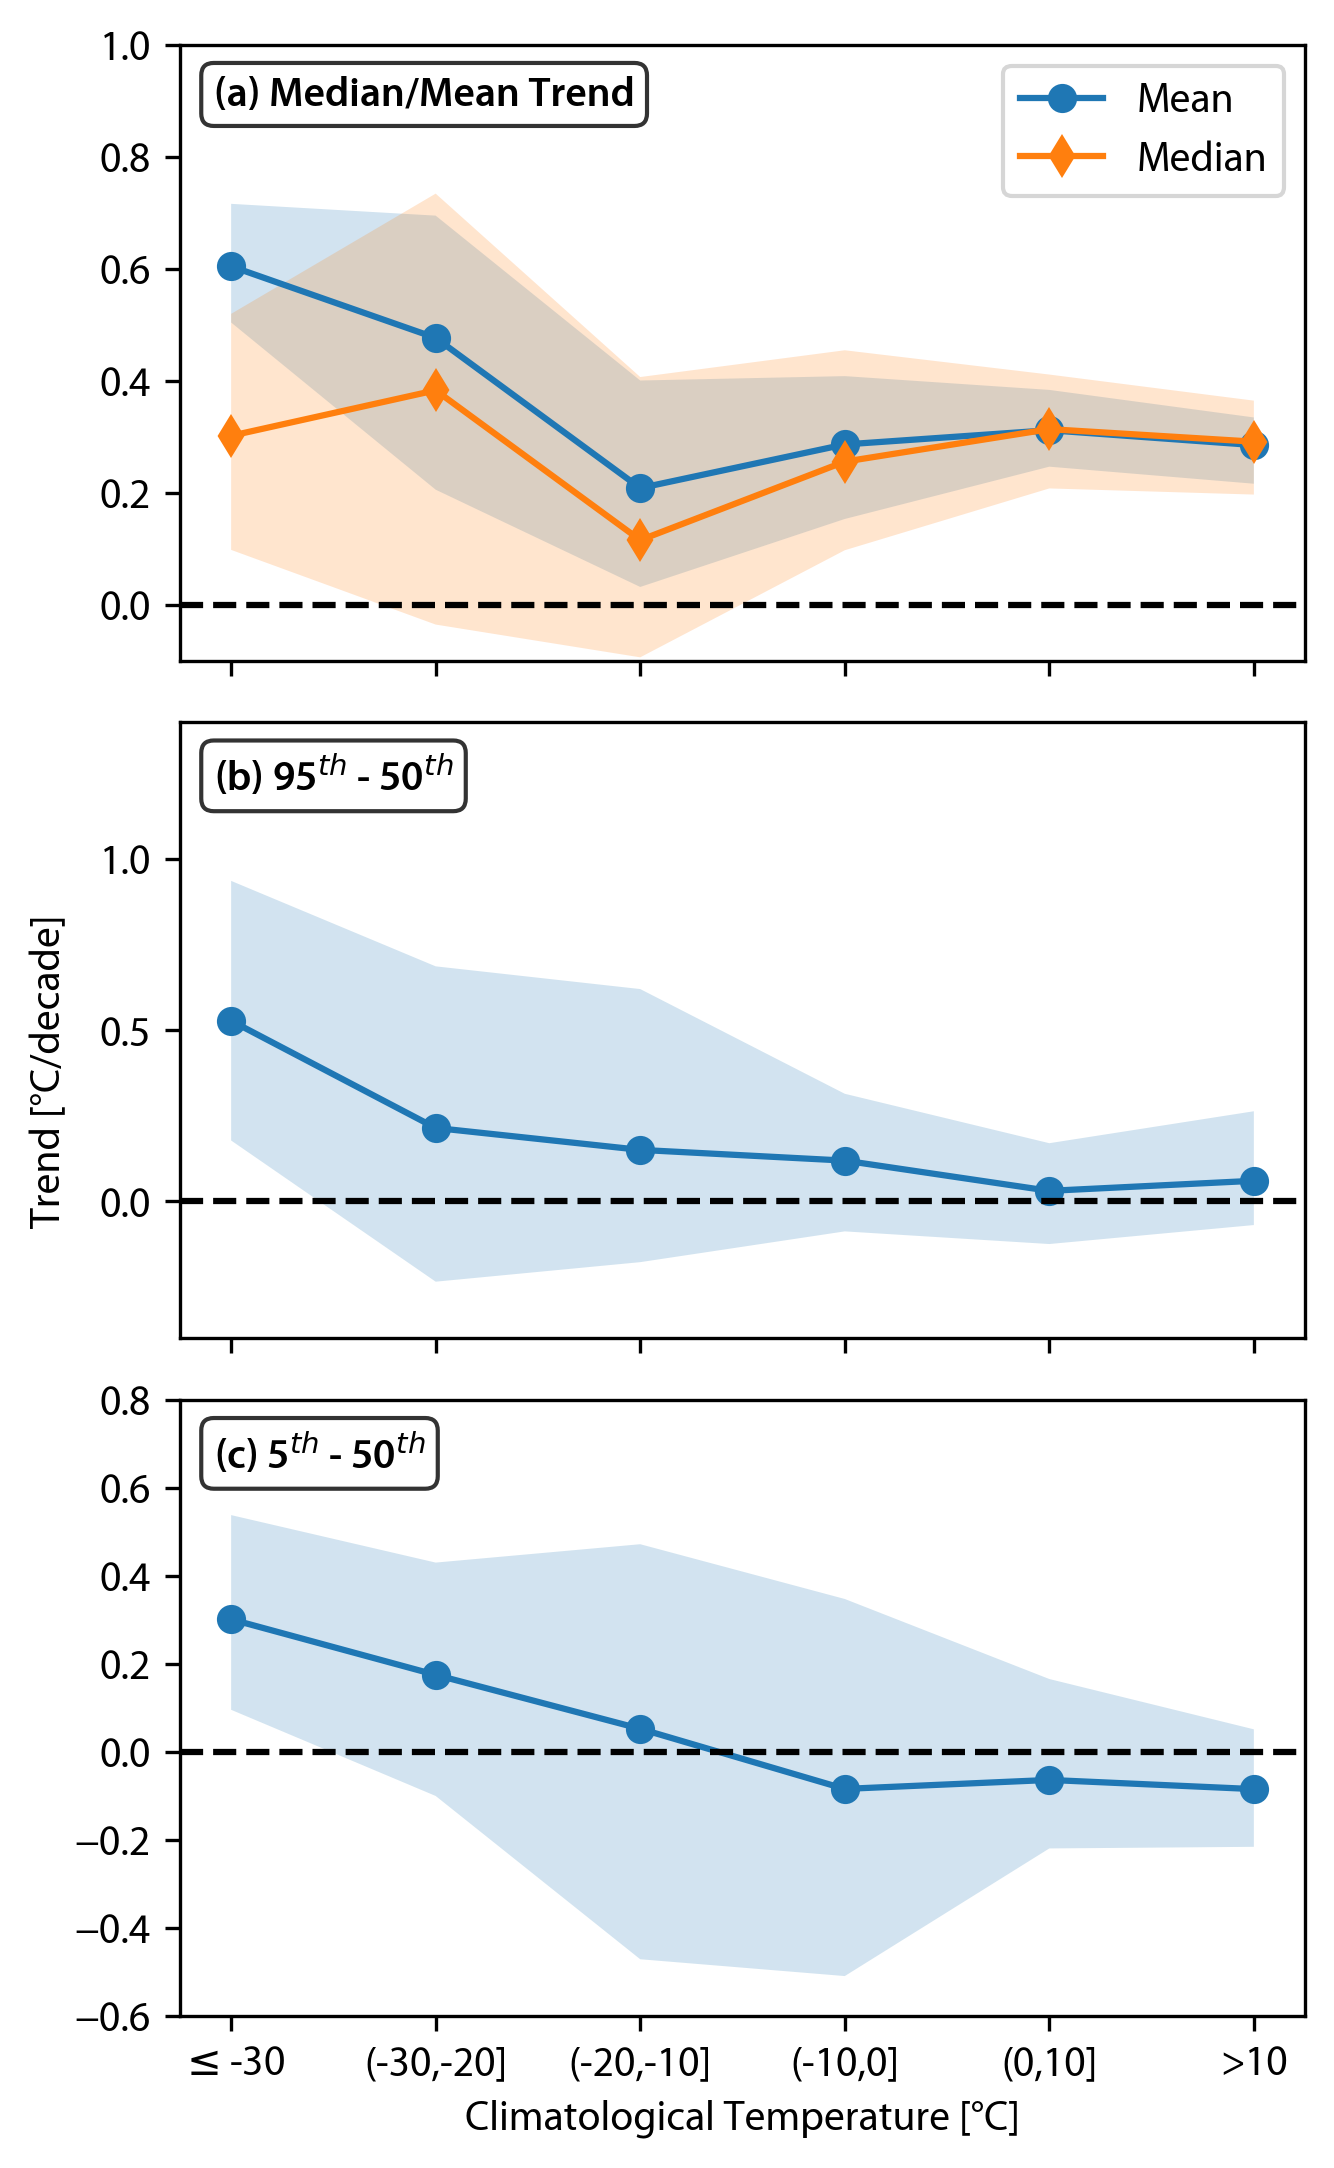

In [12]:
# recover vectorized mean trends
k_mean_v = k_median_v - diff_v

# group by climatology
# define the bins and corresponding labels
bins = [-30, -20, -10, 0, 10]
label_str = ['$\leq$' + str(bins[0])]
for i in range(len(bins)-1):
    label_str.append('(' + str(bins[i]) + ',' + str(bins[i+1]) + ']')
label_str.append('>' + str(bins[-1]))

# Digitize climatology_v based on the bins
grouped_indices = np.digitize(climatology_v, bins)
# initialize dictionaries for grouped data
k_mean_group = {}
k_median_group = {}
warm_diff_group = {}
cold_diff_group = {}
for i in range(len(bins)+1):
    k_mean_group[i] = []
    k_median_group[i] = []
    warm_diff_group[i] = []
    cold_diff_group[i] = []
# add data to respective groups
for idx, group_id in enumerate(grouped_indices):
    k_mean_group[group_id].append(k_mean_v[idx])
    k_median_group[group_id].append(k_median_v[idx])
    warm_diff_group[group_id].append(warm_diff[idx])
    cold_diff_group[group_id].append(cold_diff[idx])

low_median, mid_median, upp_median = [], [], []
low_mean, mid_mean, upp_mean = [], [], []
low_warm, mid_warm, upp_warm = [], [], []
low_cold, mid_cold, upp_cold = [], [], []
for i in range(len(bins)+1):
    low_mean.append(np.percentile(k_mean_group[i], 25))
    mid_mean.append(np.percentile(k_mean_group[i], 50))
    upp_mean.append(np.percentile(k_mean_group[i], 75))
    low_median.append(np.percentile(k_median_group[i], 25))
    mid_median.append(np.percentile(k_median_group[i], 50))
    upp_median.append(np.percentile(k_median_group[i], 75))
    low_warm.append(np.percentile(warm_diff_group[i], 25))
    mid_warm.append(np.percentile(warm_diff_group[i], 50))
    upp_warm.append(np.percentile(warm_diff_group[i], 75))
    low_cold.append(np.percentile(cold_diff_group[i], 25))
    mid_cold.append(np.percentile(cold_diff_group[i], 50))
    upp_cold.append(np.percentile(cold_diff_group[i], 75))

fig, ax = plt.subplots(3, 1, figsize=(5, 9))
ax[0].plot(np.arange(len(bins)+1), mid_mean, label='Mean', marker='o')
ax[0].fill_between(np.arange(len(bins)+1), low_mean, upp_mean, alpha=0.2)
ax[0].plot(np.arange(len(bins)+1), mid_median, label='Median', marker='d')
ax[0].fill_between(np.arange(len(bins)+1), low_median, upp_median, alpha=0.2)
ax[0].axline((0, 0), slope=0, color='black', linestyle='--')
ax[0].legend()
ax[0].set_ylim(-0.1, 1)
# Add title inside plot
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax[0].text(0.03, 0.95, '(a) Median/Mean Trend', transform=ax[0].transAxes, 
           fontsize=10, fontweight='bold', va='top', bbox=props)

ax[1].plot(np.arange(len(bins)+1), mid_warm, marker='o')
ax[1].fill_between(np.arange(len(bins)+1), low_warm, upp_warm, alpha=0.2)
ax[1].axline((0, 0), slope=0, color='black', linestyle='--')
ax[1].set_ylim(-0.4, 1.4)
ax[1].text(0.03, 0.95, '(b) 95$^{th}$ - 50$^{th}$', transform=ax[1].transAxes, 
           fontsize=10, fontweight='bold', va='top', bbox=props)

ax[2].plot(np.arange(len(bins)+1), mid_cold, marker='o')
ax[2].fill_between(np.arange(len(bins)+1), low_cold, upp_cold, alpha=0.2)
ax[2].axline((0, 0), slope=0, color='black', linestyle='--')
ax[2].set_ylim(-0.6, 0.8)
ax[2].text(0.03, 0.95, '(c) 5$^{th}$ - 50$^{th}$', transform=ax[2].transAxes, 
           fontsize=10, fontweight='bold', va='top', bbox=props)

# Set common x-axis properties on bottom subplot
ax[2].set_xticks(np.arange(len(bins)+1))
ax[2].set_xticklabels(label_str)
ax[2].tick_params(axis='x', labelrotation=0)
ax[2].set_xlabel('Climatological Temperature [°C]')  # Added x-axis label

# Remove x-axis labels from top and middle subplots
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

# Set common y-axis label
fig.text(0.05, 0.5, 'Trend [°C/decade]', va='center', rotation='vertical')

# Adjust spacing between subplots
plt.subplots_adjust(left=0.15, bottom=0.15, hspace=0.1)  # Added bottom margin for x-label
fig.savefig('figures_new/grouped_by_climatology.png')

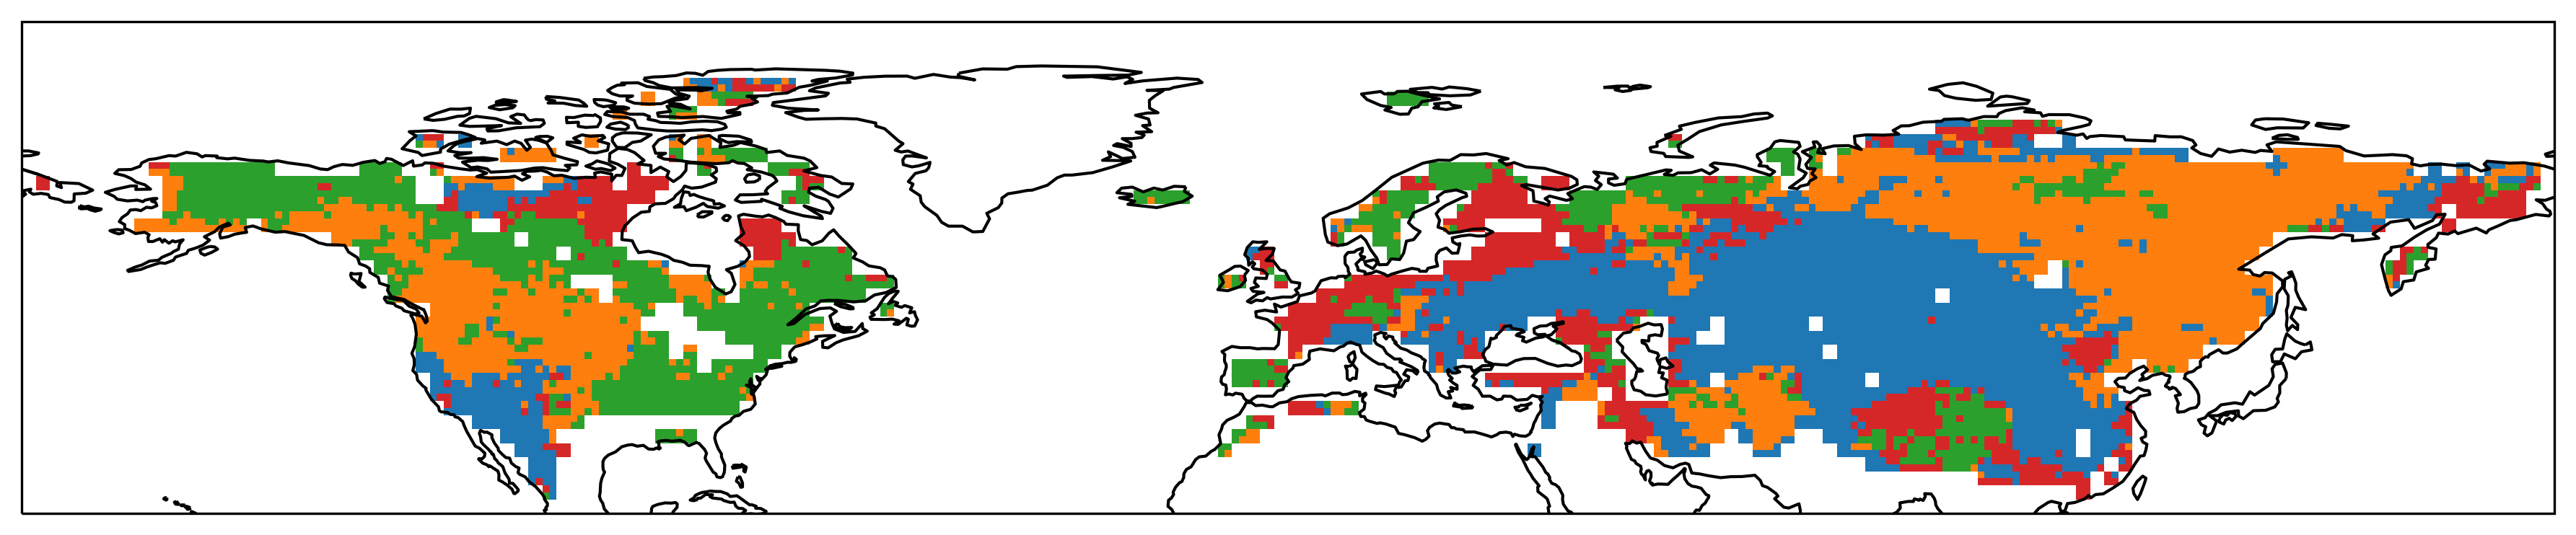

In [37]:

# Mask the ocean points
type_map_masked = np.ma.masked_where(mask == 0, type_map)

# Create the plot
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(10, 12)

# Create main map
ax = fig.add_subplot(gs[:, :], projection=ccrs.PlateCarree())

# Create custom colormap for the 4 types
colors = ['#1f77b4',  # Type I: blue (stretch-stretch)
          '#2ca02c',  # Type II: green (shrink-shrink)
          '#ff7f0e',  # Type III: orange (shrink-stretch)
          '#d62728']  # Type IV: red (stretch-shrink)

cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries=np.arange(0.5, 5.5), ncolors=4)

# Plot the map
basemap = ax.pcolormesh(lon, lat, type_map_masked, 
                       transform=ccrs.PlateCarree(),
                       cmap=cmap, norm=norm)

# Add coastlines and gridlines
ax.coastlines()
# ax.gridlines()
ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()
fig.savefig('figures_new/distribution_types.png')

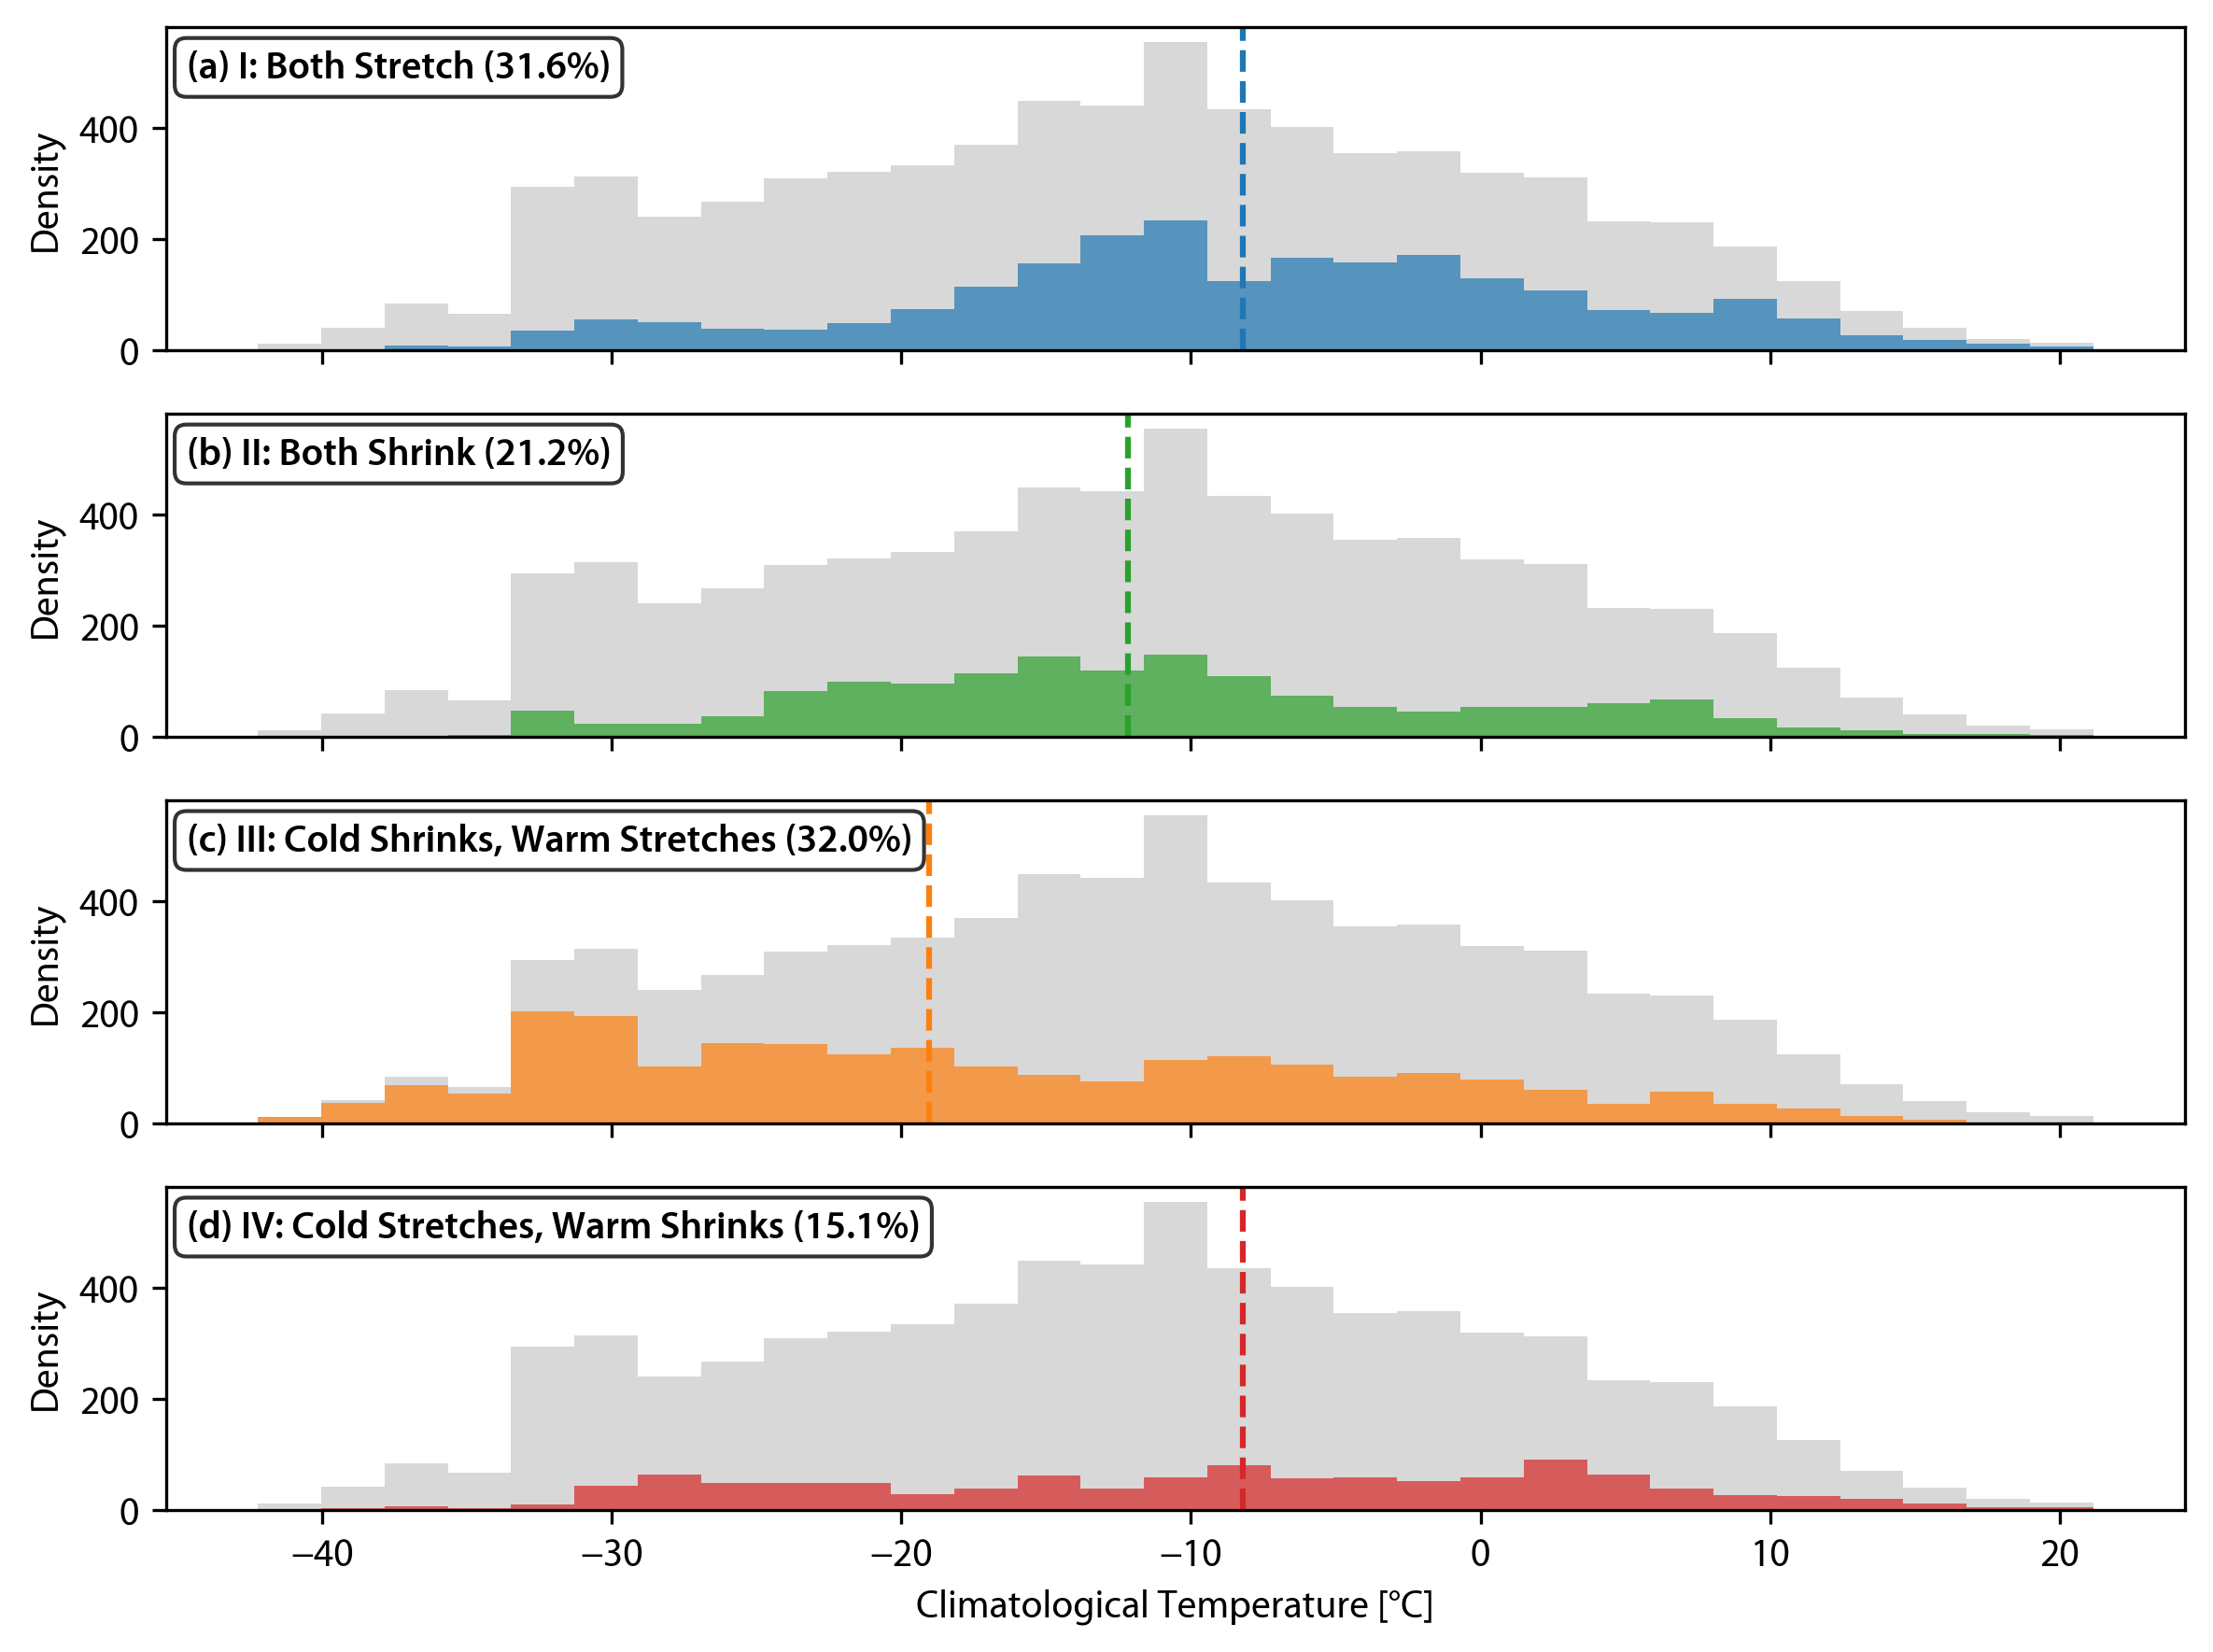


Summary Statistics:
Total valid pixels: 7200

Type 1:
Count: 2278
Mean: -7.88°C
Median: -8.22°C
Std Dev: 11.18°C

Type 2:
Count: 1529
Mean: -11.09°C
Median: -12.17°C
Std Dev: 10.97°C

Type 3:
Count: 2306
Mean: -17.15°C
Median: -19.04°C
Std Dev: 13.25°C

Type 4:
Count: 1087
Mean: -9.02°C
Median: -8.20°C
Std Dev: 12.96°C


In [65]:
# Flatten arrays
type_map_flat = type_map.flatten()
climatology_flat = climatology.flatten()

# Only keep data where type_map is non-zero and climatology is not nan
valid_mask = np.logical_and(type_map_flat != 0, ~np.isnan(climatology_flat))
type_map_flat = type_map_flat[valid_mask]
climatology_flat = climatology_flat[valid_mask]

# Calculate total valid pixels for percentage
total_valid = len(climatology_flat)

# Create figure with shared x axis
fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

# Plot settings
titles = ['(a) I: Both Stretch', 
          '(b) II: Both Shrink',
          '(c) III: Cold Shrinks, Warm Stretches',
          '(d) IV: Cold Stretches, Warm Shrinks']
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

# Get common bins for all histograms
bins = np.linspace(np.min(climatology_flat), np.max(climatology_flat), 30)

# Plot each type
for i in range(4):
    # Get data for current type
    type_data = climatology_flat[type_map_flat == (i+1)]
    # Calculate percentage
    type_percentage = len(type_data) / total_valid * 100
    
    # Plot full distribution in background
    axes[i].hist(climatology_flat, bins=bins, color='gray', 
                alpha=0.3, density=False, label='All')
    
    # Plot type-specific distribution on top
    axes[i].hist(type_data, bins=bins, color=colors[i], 
                alpha=0.7, density=False, 
                label='Type {:1d} (n={:.2f} [%])'.format(i+1, len(type_data) / 72))
    
    axes[i].axline((np.median(type_data), 0), (np.median(type_data), 1), color=colors[i], linestyle='--')
    
    title = f'{titles[i]} ({type_percentage:.1f}%)'
    # Add title and legend
    axes[i].text(0.01, 0.93, title, transform=axes[i].transAxes,
                fontsize=10, fontweight='bold', va='top', bbox=props)
    
    # Add y label only
    axes[i].set_ylabel('Density')

# Add x label only to bottom subplot
axes[-1].set_xlabel('Climatological Temperature [°C]')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Total valid pixels: {len(climatology_flat)}")
for i in range(4):
    type_data = climatology_flat[type_map_flat == (i+1)]
    print(f"\nType {i+1}:")
    print(f"Count: {len(type_data)}")
    print(f"Mean: {np.mean(type_data):.2f}°C")
    print(f"Median: {np.median(type_data):.2f}°C")
    print(f"Std Dev: {np.std(type_data):.2f}°C")

fig.savefig('figures_new/climatology_distributions_by_types.png')